In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/shmprojectdata1/QuakeCity/test.csv",header=None)

In [ ]:
!pip install natsort # Install the natsort package
import glob
import natsort #Import the natsort module

In [ ]:
from sklearn.model_selection import train_test_split
# Get image and label file paths using natsort for natural sorting
frame_list = natsort.natsorted(glob.glob("/content/drive/MyDrive/shmprojectdata1/QuakeCity/image" + '/*.' + "png"))
label_list = natsort.natsorted(glob.glob("/content/drive/MyDrive/shmprojectdata1/QuakeCity/label/ds" + '/*.' + "png"))

# Split the data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    frame_list, label_list, test_size=0.2, random_state=42
)

print(f'Training images: {len(train_images)}')
print(f'Training labels: {len(train_labels)}')
print(f'Validation images: {len(val_images)}')
print(f'Validation labels: {len(val_labels)}')

Training images: 3847
Training labels: 3847
Validation images: 962
Validation labels: 962


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Constants
IMAGE_HEIGHT = 288
IMAGE_WIDTH = 512
BATCH_SIZE = 2
NUM_CLASSES = 5

def read_image(image_path, mask=False):
    """Reads and preprocesses an image or mask using PIL.

    Args:
        image_path: Path to the image file.
        mask: Boolean indicating whether it's a mask image.

    Returns:
        The processed image as a TensorFlow tensor.
    """
    # Open image with PIL
    image_path = image_path.numpy().decode('utf-8')  # Convert tensor to string
    image = Image.open(image_path)

    if mask:
        # For masks, we expect an indexed image (1 channel)
        image = image.convert('P')  # Ensure it is in palette mode (indexed)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.NEAREST)  # Resize using nearest neighbor for masks
        mask_array = np.array(image)  # Convert to numpy array for processing
        mask_tensor = tf.convert_to_tensor(mask_array, dtype=tf.uint8)  # Convert to tensor

        # Here, we could apply a mask to ignore specific indices if required
        mask_tensor = tf.where(mask_tensor >= 4, 4, mask_tensor)

        return mask_tensor  # Return the tensor directly
    else:
        image = image.convert('RGB')  # Ensure image is in RGB mode
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize
        return tf.convert_to_tensor(np.array(image), dtype=tf.uint8)  # Convert to tensor

def load_data(image_path, mask_path):
    """Loads and preprocesses an image and its corresponding mask.

    Args:
        image_path: Path to the image file.
        mask_path: Path to the mask file.

    Returns:
        A tuple containing the processed image and mask as TensorFlow tensors.
    """
    image = read_image(image_path)
    mask = read_image(mask_path, mask=True)
    return image, mask

def load_data_tf(image_path, mask_path):
    """Wrapper function to allow reading images and masks in graph mode."""
    return tf.py_function(load_data, [image_path, mask_path], [tf.uint8, tf.uint8])

def data_generator(image_list, mask_list):
    """Creates a TensorFlow data generator.

    Args:
        image_list: List of image paths.
        mask_list: List of mask paths.

    Returns:
        A TensorFlow Dataset object.
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Set the shape of the dataset
    dataset = dataset.map(lambda x, y: (tf.reshape(x, [IMAGE_HEIGHT, IMAGE_WIDTH, 3]),
                                         tf.reshape(y, [IMAGE_HEIGHT, IMAGE_WIDTH])),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

# List of image and mask paths

train_image_paths = train_images
train_mask_paths = train_labels
val_image_paths = val_images
val_mask_paths =val_labels
# Verification: Print the paths to check for errors
print("Sample train image path:", train_image_paths[0])
print("Sample train mask path:", train_mask_paths[0])
print("Sample val image path:", val_image_paths[0])
print("Sample val mask path:", val_mask_paths[0])

# Disable eager execution before model compilation and fitting
tf.config.run_functions_eagerly(False)

# Create the datasets
train_dataset = data_generator(train_image_paths, train_mask_paths)
val_dataset = data_generator(val_image_paths, val_mask_paths)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

# Optional: Check the shapes and values of the masks
for images, masks in train_dataset.take(1):
    print("Images batch shape:", images.shape)  # Expected: (BATCH_SIZE, 288, 512, 3)
    print("Masks batch shape:", masks.shape)    # Expected: (BATCH_SIZE, 288, 512)


Sample train image path: /content/drive/MyDrive/shmprojectdata1/QuakeCity/image/A10403.png
Sample train mask path: /content/drive/MyDrive/shmprojectdata1/QuakeCity/label/ds/A10403.png
Sample val image path: /content/drive/MyDrive/shmprojectdata1/QuakeCity/image/A30131.png
Sample val mask path: /content/drive/MyDrive/shmprojectdata1/QuakeCity/label/ds/A30131.png
Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(2, 288, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(2, 288, 512), dtype=tf.uint8, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(2, 288, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(2, 288, 512), dtype=tf.uint8, name=None))>
Images batch shape: (2, 288, 512, 3)
Masks batch shape: (2, 288, 512)


In [ ]:
import keras
from keras import layers
from keras import ops

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_height,image_width ,num_classes):
    model_input = keras.Input(shape=(image_height,image_width, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
        # Freeze ResNet50 layers
    for layer in resnet50.layers:
        layer.trainable = False
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_height // 4 // x.shape[1], image_width // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_height // x.shape[1], image_width // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(IMAGE_HEIGHT,IMAGE_WIDTH, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 288, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 288, 512)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 288, 512)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 288, 512)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 288, 512, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 288, 512, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 294, 518, 3)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 144, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 144, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 144, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 146, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 72, 128, 64)    │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 72, 128, 64)    │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 72, 128, 64)    │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 72, 128, 64)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 72, 128, 64)    │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,853,381 (45.22 MB)

 Trainable params: 3,527,269 (13.46 MB)

 Non-trainable params: 8,326,112 (31.76 MB)

In [ ]:
import keras
# Load the model correctly using keras.models.load_model
model = keras.models.load_model('/content/drive/MyDrive/shmprojectdata1/QuakeCity/ds_fulldata_1epoch.keras')

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)



In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=2,validation_steps=len(val_dataset))

Epoch 1/2
 727/1923 ━━━━━━━━━━━━━━━━━━━━ 1:58:03 6s/step - accuracy: 0.8365 - loss: 0.3986

In [ ]:
model.save('/content/drive/MyDrive/shmprojectdata1/QuakeCity/ds_fulldata_3epochs.keras')

In [ ]:
import tensorflow as tf

def iou_per_class(y_true, y_pred, num_classes):
    """
    Compute the Intersection over Union (IoU) for each class.

    Args:
        y_true: Ground truth masks (should be integer class labels).
        y_pred: Predicted masks (should be in softmax format).
        num_classes: The number of classes in the segmentation task.

    Returns:
        A list of IoU scores for each class.
    """
    # Convert predictions to class labels
    y_pred = tf.argmax(y_pred, axis=-1)  # Assuming y_pred is softmaxed

    # Remove the unnecessary squeeze operation if y_true has shape (batch_size, image_height, image_width)
    # y_true = tf.squeeze(y_true, axis=-1)  # Remove the last dimension if needed # comment out the line causing error

    iou_scores = []

    for i in range(num_classes):
        # Create masks for the current class
        true_mask = tf.cast(y_true == i, tf.float32)  # Ground truth mask for class i
        pred_mask = tf.cast(y_pred == i, tf.float32)  # Predicted mask for class i

        # Calculate intersection and union
        intersection = tf.reduce_sum(true_mask * pred_mask)
        union = tf.reduce_sum(true_mask) + tf.reduce_sum(pred_mask) - intersection

        # Calculate IoU for the current class
        iou = intersection / (union + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero
        iou_scores.append(iou)

    return iou_scores

In [ ]:
# Define the model's compilation with accuracy and IoU per class
# Define the IoU metric with a name using functools.partial
from functools import partial

iou_metric = partial(iou_per_class, num_classes=NUM_CLASSES)
iou_metric.__name__ = 'iou_per_class'  # Give the partial function a name

model.compile(
    optimizer='adam',  # Choose your optimizer
    loss='sparse_categorical_crossentropy',  # Assuming sparse labels
    metrics=[
        'accuracy',  # Adds accuracy as a metric
        iou_metric # IoU per class with a name
    ]
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1  # Change to the desired number of epochs
)

# Extract and print IoU and accuracy scores
iou_scores = history.history['iou_per_class']  # Training IoU per class
val_iou_scores = history.history['val_iou_per_class']  # Validation IoU per class
accuracy_scores = history.history['accuracy']  # Training accuracy
val_accuracy_scores = history.history['val_accuracy']  # Validation accuracy

print("Training IoU Scores:", iou_scores)
print("Validation IoU Scores:", val_iou_scores)
print("Training Accuracy:", accuracy_scores)
print("Validation Accuracy:", val_accuracy_scores)

10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.7351 - iou_per_class: 0.3533 - loss: 1.2793 - val_accuracy: 0.4326 - val_iou_per_class: 0.1462 - val_loss: 7.0050
Training IoU Scores: [0.31432607769966125]
Validation IoU Scores: [0.14619114995002747]
Training Accuracy: [0.6949313879013062]
Validation Accuracy: [0.4326222836971283]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Define index to color mapping (reverse of color_to_index)
index_to_color = {
    # 0: (202, 150, 150),  # wall
    # 1: (198, 186, 100),  # beam
    # 2: (167, 183, 186),  # column
    # 3: (255, 255, 133),  # window frame
    # 4: (192, 192, 206),  # window pane
    # 5: (32, 80, 160),    # balcony
    # 6: (193, 134, 1),    # slab
    # 7: (70, 70, 70)    # ignore
    0 :(0,255,0),
		1 :(150,250,0),
		2 :(255,225,50),
		3 :(255,0,0),
		4:(128,128,128)
  }

def map_indices_to_colors(indexed_mask):
    """Maps each index in the mask to its corresponding color for visualization."""
    # Squeeze the mask to 2D if it has an extra dimension (e.g., (height, width, 1))
    if indexed_mask.ndim == 3 and indexed_mask.shape[-1] == 1:
        indexed_mask = np.squeeze(indexed_mask, axis=-1)

    # Get the height and width of the mask
    height, width = indexed_mask.shape

    # Create an empty color image to store the mapped colors
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Map each index to its color
    for index, color in index_to_color.items():
        color_mask[indexed_mask == index] = color

    return color_mask


def display_results(image, ground_truth, prediction):
    """
    Displays the original image, ground truth, and model prediction side by side.

    Args:
        image: Original input image (RGB format expected).
        ground_truth: Ground truth mask.
        prediction: Model's predicted mask.
    """
    # Ensure the original image has 3 color channels
    if image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)

    # Map prediction indices to colors for better visualization
    prediction_color = map_indices_to_colors(prediction)

    # Plotting the images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.astype(np.uint8))  # Display original image in color
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Ground truth in color
    ground_truth_color = map_indices_to_colors(ground_truth)
    axes[1].imshow(ground_truth_color)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # Model prediction in color
    axes[2].imshow(prediction_color)
    axes[2].set_title("Model Prediction")
    axes[2].axis("off")

    plt.show()

# Example usage:
for image, ground_truth in val_dataset.take(1):  # Take one batch from validation data
    prediction = model.predict(image)  # Get the model's prediction for this image
    prediction = tf.argmax(prediction, axis=-1)  # Get the predicted class for each pixel
    prediction = prediction[..., tf.newaxis]  # Expand dimensions to match mask shape if needed

    # Convert tensors to numpy arrays
    image_np = image[1].numpy()  # First image in the batch
    ground_truth_np = ground_truth[1].numpy()
    prediction_np = prediction[1].numpy()
    print(np.unique(prediction_np))
    print(np.unique(ground_truth_np))
    print(image_np.shape)
    print(ground_truth_np.shape)
    print(prediction_np.shape)

    # Display the results
    display_results(image_np, ground_truth_np, prediction_np)


Image mode: P
Image shape: (1080, 1920)
Unique values in the image: [  0   1   2   3   4 100]


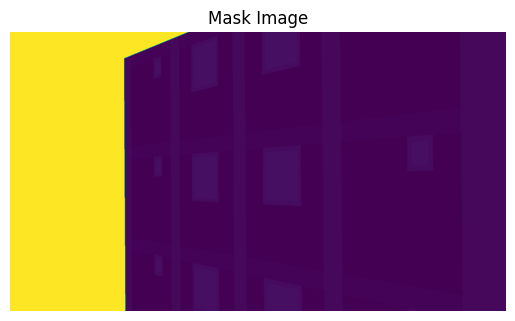

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image_path = "/content/drive/MyDrive/QuakeCity/label/component/A10101.png"

# Load the image using PIL
image = Image.open(image_path)

# Get image mode
image_mode = image.mode
print("Image mode:", image_mode)

# Convert the image to a NumPy array
image_np = np.array(image)

# Get image shape
image_shape = image_np.shape
print("Image shape:", image_shape)

# Get unique values in the image
unique_values = np.unique(image_np)
print("Unique values in the image:", unique_values)

# Display the image
plt.imshow(image_np)
plt.axis("off")
plt.title("Mask Image")
plt.show()